In [1]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score,GridSearchCV

C:\Users\cribr\AppData\Local\Temp\ipykernel_2004\1976061878.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_excel('../data/model_annotations_liwc_h.xlsx')
df_human = pd.read_excel("../data/r1_r2_annotations_liwc_h.xlsx")

We drop the text column (as the unsupervised function uses 'proc_text') and the Segment one (as it is irrelevant and with a single value).

In [3]:
df.drop(['text'],axis=1,inplace=True)

We modify the human-annotated dataset to match with the model-annotated one. 
This is done by removing the annotators columns (A1,..,A6), the roundID, taking only the rows where there was a majority and renaming the target column to 'model_unanimous'.

In [4]:
df_human.rename({'majority_vote':'model_unanimous'},axis=1, inplace=True)
df_human.drop(['text','A1','A2','A3','A4','A5','A6','roundID'], axis=1,inplace=True)
df_human=df_human[df_human['model_unanimous']!='NoMajority']

In [5]:
df_human

proc_text model_unanimous  \
0    Fuck you china. I was 2 years clear of severe ...              PP   
1    Feeling so off today and I can’t tell if this ...              PP   
2    Good lord people we need to stop having people...              PP   
3    I'm telling yall, Chill the fuck out!! This Vi...              PO   
4    Episode of #CoronaVirus panic. Man took his gl...              PP   
..                                                 ...             ...   
512  Afternoon all, \n\nToday I share with you the ...              UN   
513  In the UK, the chasm betwn people’s willingnes...              PO   
516  Stay physically fit &amp; healthy during self-...              UN   
518  I have just uploaded my 11th video in my serie...              UN   
519  #Part_1: #CORONAVIRUS &amp; #KASHMIR : Number ...              PO   

     Segment  WC  Analytic  Clout  Authentic   Tone    WPS  BigWords  ...  \
0          1  26      4.85   7.93      81.58   1.00   8.67     26.92  ...   
1          1  25      1.00   1.00      85.71   1.00  12.50     16.00  ...   
2          1  42     29.12  40.06      72.58   1.00  14.00     21.43  ...   
3          1  43     30.58  17.05      82.44   3.38   4.78     20.93  ...   
4          1  58     63.33   9.86      97.87   1.05   9.67      8.62  ...   
..       ...  ..       ...    ...        ...    ...    ...       ...  ...   
512        1  26     89.52  98.04      11.63  99.00  26.00     50.00  ...   
513        1  41     99.00  26.81      87.24   1.00  20.50     36.59  ...   
516        1  40     92.56  26.50      78.67   2.86   8.00     32.50  ...   
518        1  40     89.52  26.50      45.52   1.00  13.33     25.00  ...   
519        1  35     95.41  13.30       4.17   1.98   7.00     34.29  ...   

     nonflu  filler  AllPunc  Period  Comma  QMark  Exclam  Apostro  OtherP  \
0       0.0    0.00    26.92    7.69   3.85   0.00    0.00     3.85   11.54   
1       0.0    0.00    28.00   12.00   0.00   0.00    0.00     8.00    8.00   
2       0.0    0.00    19.05    4.76   0.00   0.00    0.00     4.76    9.52   
3       0.0    0.00    37.21    4.65   2.33   0.00   23.26     2.33    4.65   
4       0.0    1.72    20.69   10.34   5.17   0.00    0.00     3.45    1.72   
..      ...     ...      ...     ...    ...    ...     ...      ...     ...   
512     0.0    0.00    46.15    0.00   3.85   0.00    0.00     0.00   42.31   
513     0.0    0.00    31.71    0.00  12.20   0.00    2.44     2.44   14.63   
516     0.0    0.00    37.50   12.50   2.50   0.00    0.00     0.00   22.50   
518     0.0    0.00    32.50    5.00   5.00   0.00    0.00     5.00   17.50   
519     0.0    0.00    62.86    8.57   2.86   2.86    0.00     0.00   48.57   

     Emoji  
0     0.00  
1    16.00  
2     0.00  
3     0.00  
4     0.00  
..     ...  
512   3.85  
513   0.00  
516   0.00  
518   0.00  
519   2.86  

[353 rows x 121 columns]

We can finally concatenate the two datasets.

In [6]:
df_new = pd.concat([df,df_human],axis=0)

In [7]:
df_new = df_new[~df_new.duplicated()]


In [8]:
df_new.head()

proc_text model_unanimous  Segment  \
0  Dear World:family_man_woman_girl_boy:, you nee...              PO        1   
1  .@fordnation says releasing the projection mod...              PO        1   
2  "Neurologists around the world say that a smal...              UN        1   
3  Coronavirus: More than one million cases confi...              UN        1   
4  This is my Gov, @henrymcmaster, today, 4/2/202...              UN        1   

   WC  Analytic  Clout  Authentic   Tone   WPS  BigWords  ...  nonflu  filler  \
0  32     52.84  75.49       1.63   1.00  16.0     46.88  ...     0.0     0.0   
1  28     96.35   3.12      48.09   1.00  28.0     35.71  ...     0.0     0.0   
2  34     93.03  24.36       4.60  20.23  17.0     29.41  ...     0.0     0.0   
3  34     93.03  40.06      12.44   1.85  17.0     41.18  ...     0.0     0.0   
4  42     81.45  54.27      72.58   3.20  10.5     30.95  ...     0.0     0.0   

   AllPunc  Period  Comma  QMark  Exclam  Apostro  OtherP  Emoji  
0    59.38    3.13   6.25    0.0     0.0     0.00   50.00   12.5  
1    32.14    3.57   3.57    0.0     0.0     3.57   21.43    0.0  
2    20.59    2.94   0.00    0.0     0.0     2.94   14.71    0.0  
3    14.71    5.88   0.00    0.0     0.0     0.00    8.82    0.0  
4    38.10    7.14  11.90    0.0     0.0     2.38   16.67    0.0  

[5 rows x 121 columns]

In [9]:
def add_unsupervised_columns(data):
    text = data['proc_text']
    X = data.drop(columns=['model_unanimous','proc_text'], axis=1)
    y = data['model_unanimous']
    
    with open('models/tfidf_vectorizer.pkl','rb') as f1:
        tfidf=pickle.load(f1)
        
    with open('models/thresholder.pkl','rb') as f2:
        thresholder=pickle.load(f2)
        
    tfidf_wm = tfidf.transform(text)        # we do not use fit_transform as our pickled models were already fit
    tfidf_tokens = tfidf.get_feature_names_out()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
    
    X.reset_index(inplace=True,drop=True)
    y.reset_index(inplace=True,drop=True)
    
    X = pd.concat([df_tfidfvect, X], axis=1)

    X_high_variance = thresholder.transform(X)
    mask = thresholder.get_support(indices=True)
    feature_names_high_variance = X.columns[mask]
    X_high_variance = pd.DataFrame(X_high_variance, columns=feature_names_high_variance)
    
    return X_high_variance,y

In [10]:
X,y=add_unsupervised_columns(df_new)
X.shape,y.shape

((13031, 144), (13031,))

The things done by this functions are explained in our unsupervised section, as the same code was used.

In [11]:
round(y.value_counts()*100/len(y),3)

model_unanimous
PO    54.877
UN    37.227
PP     7.897
Name: count, dtype: float64

We can notice that there seem to be a class inbalance with PP being quite rare. In some cases some techniques like under or oversampling can help with the result, but we already tried it in the 'workflow_with_imblearn' notebook.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X ,y, shuffle=True, test_size = 0.2,random_state=704)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10424, 144), (2607, 144), (10424,), (2607,))

In [13]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()

X_train_sampled,y_train_sampled = sampler.fit_resample(X_train,y_train)

In [14]:
y_train_sampled.shape, y_train_sampled.value_counts()

((17196,),
 model_unanimous
 UN    5732
 PO    5732
 PP    5732
 Name: count, dtype: int64)

We shuffle the data at split time, this way the model will train and test on data coming from both datasets (currently the human-annotated dataset was appended at the end of the other one).

In [15]:
def reset_idx():
    X_train.reset_index(drop=True,inplace=True)
    X_test.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)

In [16]:
reset_idx()

In [17]:
X_train.head()

19       amp  breath  buying  chill  coronavirus  covid   covid19  \
0  0.0  0.000000     0.0     0.0    0.0     0.000000    0.0  0.000000   
1  0.0  0.000000     0.0     0.0    0.0     0.000000    0.0  0.440843   
2  0.0  0.000000     0.0     0.0    0.0     0.434889    0.0  0.000000   
3  0.0  0.000000     0.0     0.0    0.0     0.000000    0.0  0.731330   
4  0.0  0.939614     0.0     0.0    0.0     0.000000    0.0  0.250288   

   covid_19       don  ...  nonflu  filler  AllPunc  Period  Comma  QMark  \
0  0.659896  0.000000  ...     0.0     0.0    33.33    0.00   0.00   5.56   
1  0.000000  0.797895  ...     0.0     0.0    55.56   16.67   0.00   0.00   
2  0.000000  0.000000  ...     0.0     0.0    34.09    2.27   9.09   2.27   
3  0.000000  0.000000  ...     0.0     0.0    41.18    5.88   5.88   5.88   
4  0.000000  0.000000  ...     0.0     0.0    26.83    4.88   4.88   0.00   

   Exclam  Apostro  OtherP  Emoji  
0     0.0     0.00   27.78   5.56  
1     0.0    16.67   22.22   0.00  
2     0.0     0.00   20.45   0.00  
3     0.0     0.00   23.53   0.00  
4     0.0     2.44   14.63   0.00  

[5 rows x 144 columns]

In [21]:
X_train_sampled.dtypes.unique()

array([dtype('float64')], dtype=object)

In [22]:
X_train_sampled.isna().sum().sum()

0

In [23]:
X_train_sampled.shape

(17196, 144)

In [24]:
def plot_pdf(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.histplot(data[data.columns[i]],kde=True)
    plt.xlabel(data.columns[i])
    plt.grid()
  plt.show()

def plot_box(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.boxplot(data[data.columns[i]])
    plt.xlabel(data.columns[i])
  plt.show()

In [25]:
X_train_sampled.columns

Index(['19', 'amp', 'breath', 'buying', 'chill', 'coronavirus', 'covid',
       'covid19', 'covid_19', 'don',
       ...
       'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'QMark', 'Exclam',
       'Apostro', 'OtherP', 'Emoji'],
      dtype='object', length=144)

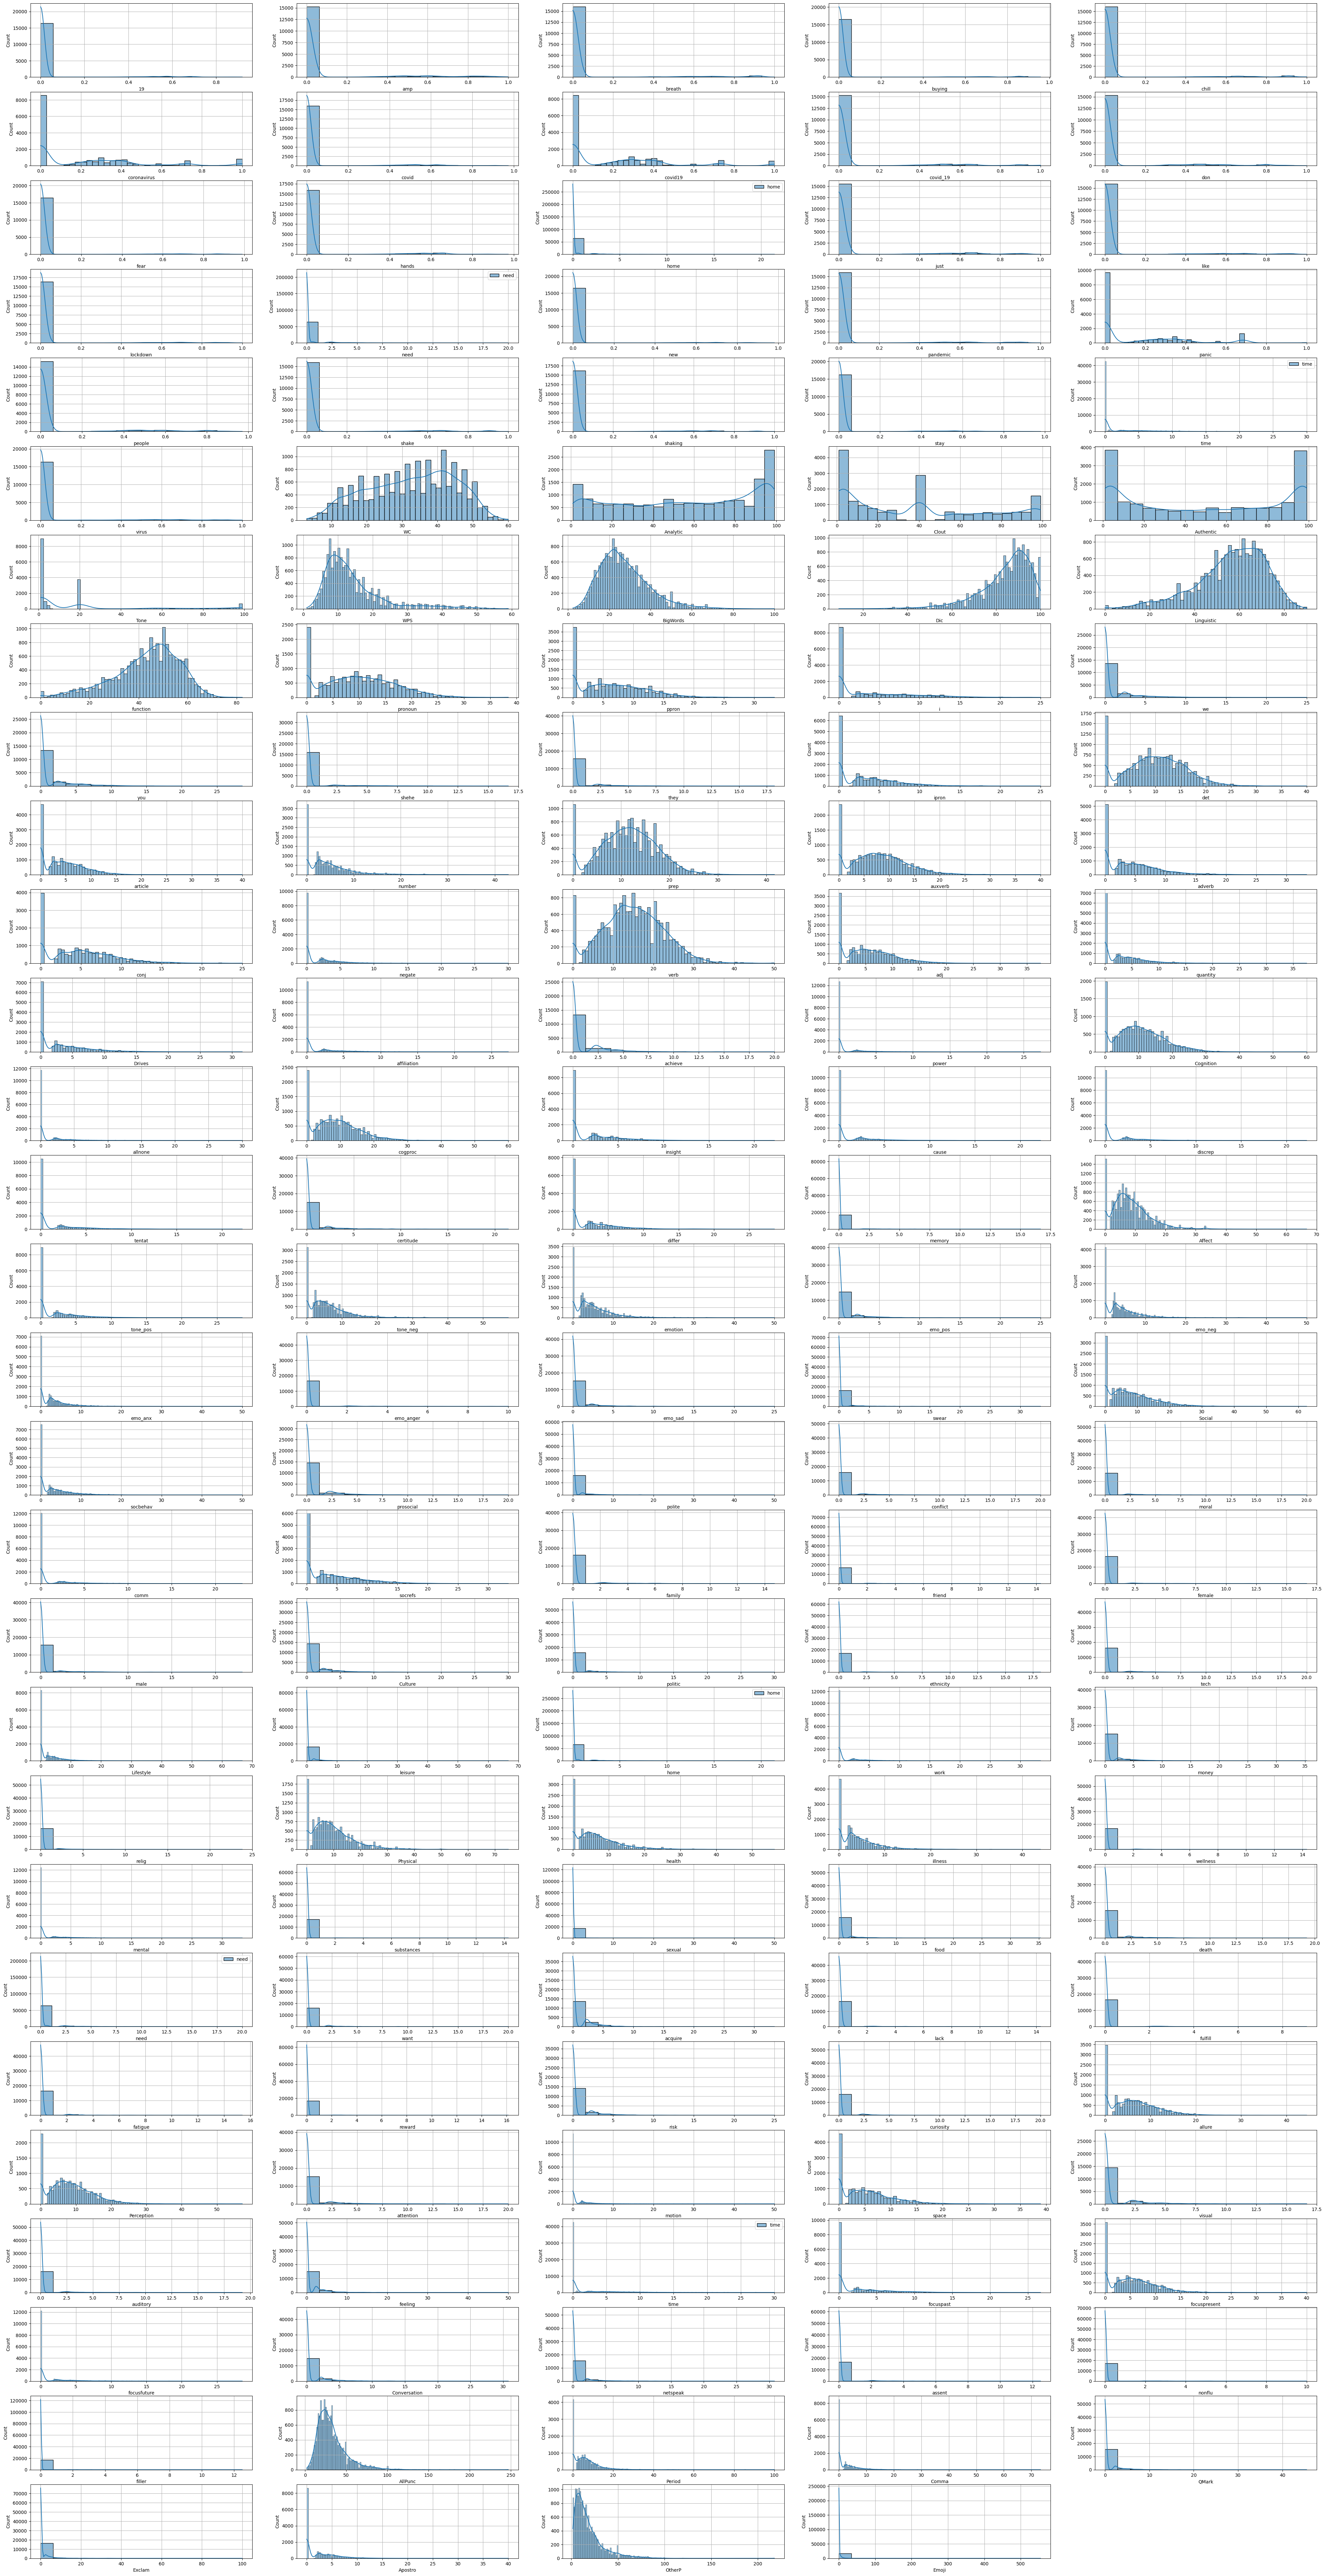

In [26]:
plot_pdf(X_train_sampled,29,5, size=(50,100))

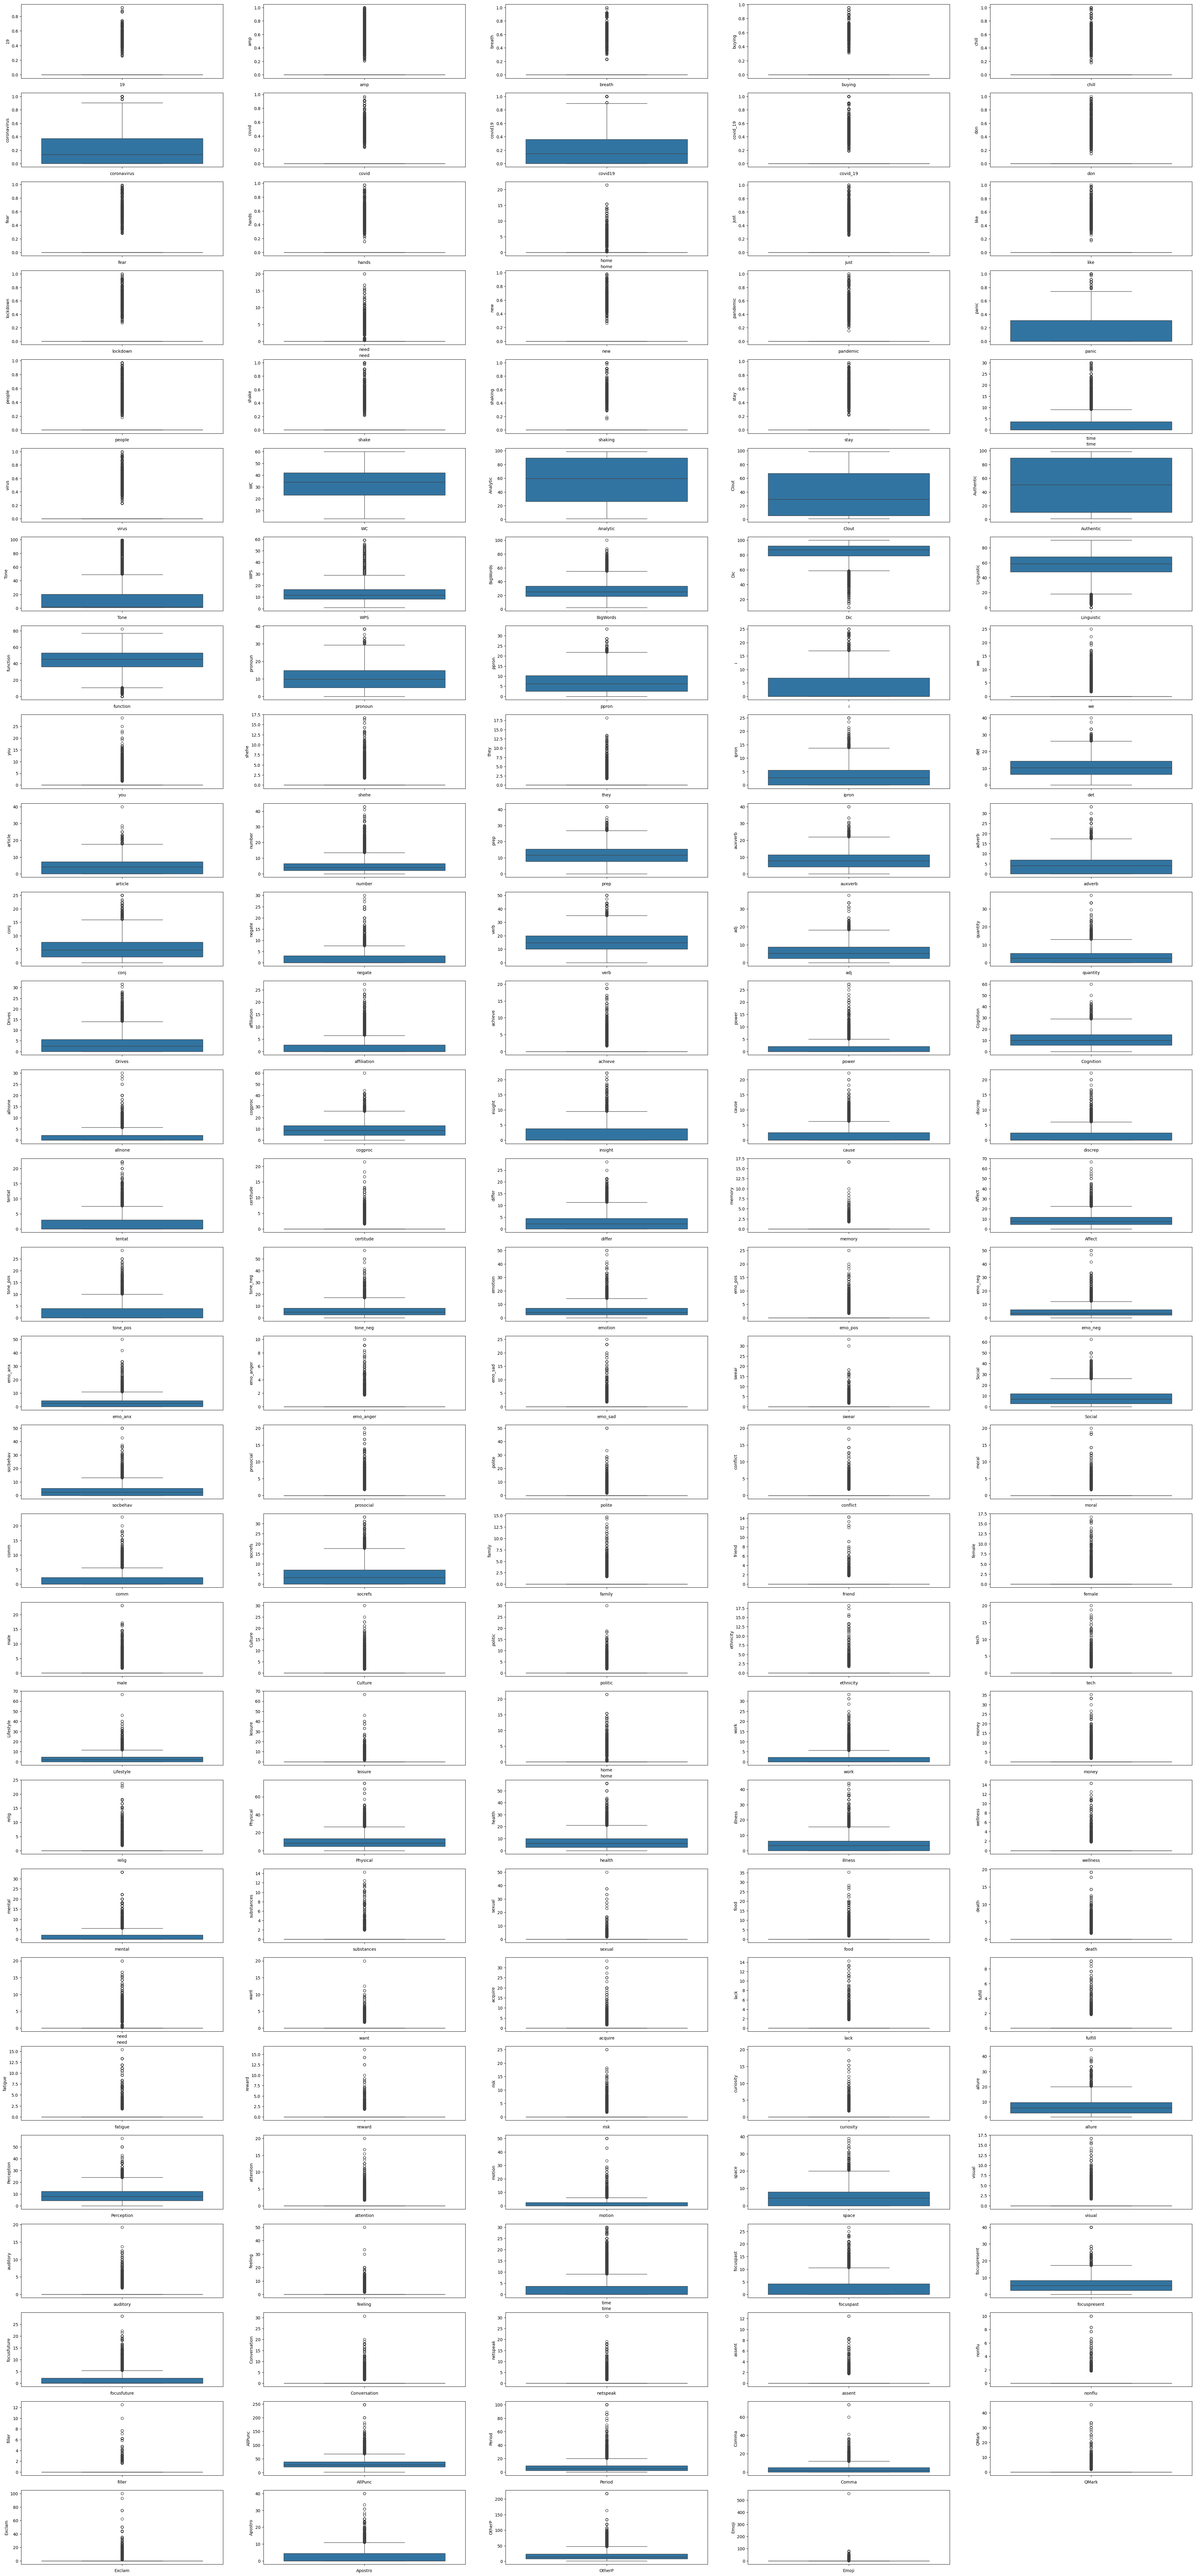

In [27]:
plot_box(X_train_sampled,29,5, size=(50,110))

We define a helper function that plots the confusion matrix and prints the sklearn classification report for both train and test set. For train set it also shows the cross-validation performance(to address how much the model is affected by the split and is able to generalize).

In [28]:
def evaluate_classifier(clf,X_train,y_train,X_test,y_test):
    print(f"TRAIN PERFORMANCE")
    y_pred_train=clf.predict(X_train)
    vals_scores=cross_val_score(clf,X_train,y_train)
    print(f"Cross validation scores: {vals_scores} | Mean: {sum(vals_scores)/len(vals_scores)}")

    print(classification_report(y_train,y_pred_train))

    conf_m=confusion_matrix(y_train,y_pred_train)

    ConfusionMatrixDisplay(conf_m).plot()


    print(f"\n\nTEST PERFORMANCE")
    y_pred_test=clf.predict(X_test)

    print(classification_report(y_test,y_pred_test))

    conf_m=confusion_matrix(y_test,y_pred_test)

    ConfusionMatrixDisplay(conf_m).plot()

c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

TRAIN PERFORMANCE


c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross validation scores: [0.958753   0.95443645 0.96019185 0.96258993 0.96305182] | Mean: 0.9598046092876178
              precision    recall  f1-score   support

          PO       0.99      0.97      0.98      5732
          PP       0.71      0.93      0.80       814
          UN       0.97      0.93      0.95      3878

    accuracy                           0.95     10424
   macro avg       0.89      0.95      0.91     10424
weighted avg       0.96      0.95      0.96     10424



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.99      0.97      0.98      1419
          PP       0.71      0.91      0.79       215
          UN       0.97      0.93      0.95       973

    accuracy                           0.95      2607
   macro avg       0.89      0.94      0.91      2607
weighted avg       0.96      0.95      0.95      2607



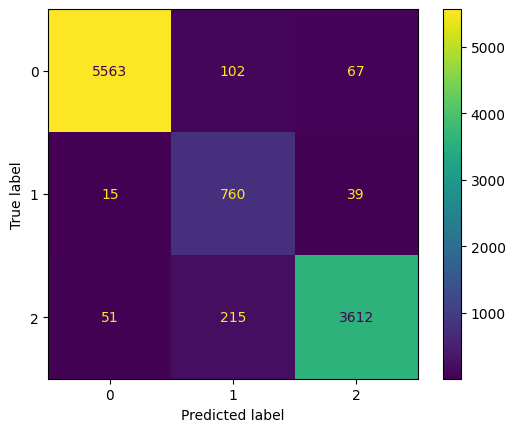

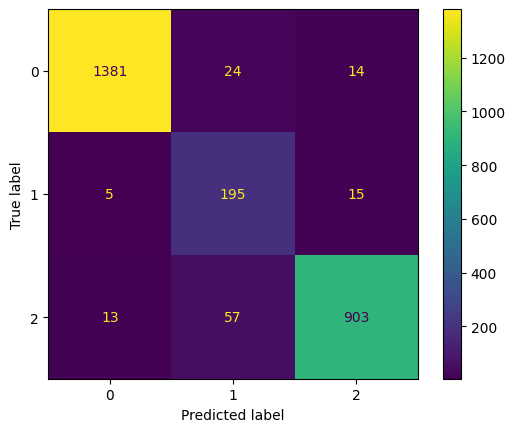

In [30]:
from sklearn.linear_model import LogisticRegression

param_grid={'penalty':['l1','l2',None],'C':[0.001,0.01,0.1,1,10]}

reg = GridSearchCV(LogisticRegression(max_iter=500),param_grid=param_grid)

reg.fit(X_train_sampled, y_train_sampled)

evaluate_classifier(reg,X_train,y_train,X_test,y_test)

In [23]:
with open('models/regression_unsup.pkl','wb') as file:
    pickle.dump(reg, file)

In [31]:
from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators': [100,500], 'max_depth':[3,5,7]}

rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

rf.fit(X_train_sampled,y_train_sampled)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7], 'n_estimators': [100, 500]})

In [65]:
rf.best_params_

{'max_depth': 7, 'n_estimators': 500}

TRAIN PERFORMANCE
Cross validation scores: [0.95107914 0.9558753  0.95251799 0.96546763 0.96017274]
              precision    recall  f1-score   support

          PO       0.98      1.00      0.99      5732
          PP       0.96      0.68      0.80       814
          UN       0.96      0.99      0.98      3878

    accuracy                           0.97     10424
   macro avg       0.97      0.89      0.92     10424
weighted avg       0.97      0.97      0.97     10424



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.97      1.00      0.98      1419
          PP       0.91      0.55      0.68       215
          UN       0.93      0.99      0.96       973

    accuracy                           0.95      2607
   macro avg       0.94      0.84      0.88      2607
weighted avg       0.95      0.95      0.95      2607



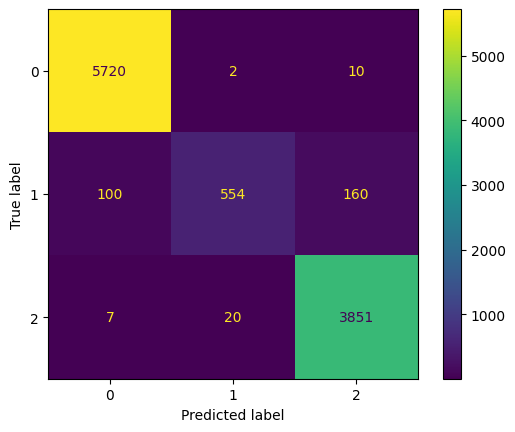

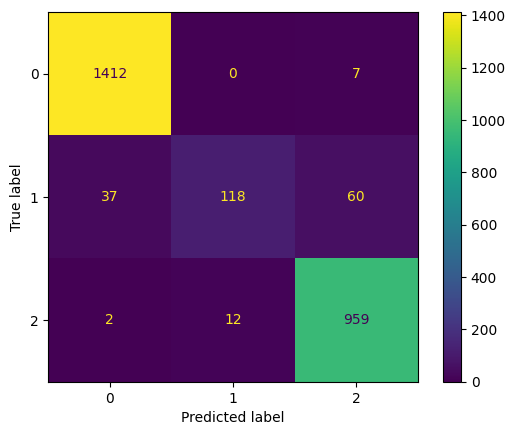

In [ ]:
evaluate_classifier(rf,X_train,y_train,X_test,y_test)

The random forest performs slightly worse than the softmax model, and it also takes longer.

In [ ]:
with open('models/rf_unsup.pkl','wb') as file:
    pickle.dump(rf, file)